In [ ]:

## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-afqd_zji
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-afqd_zji
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit c7c0429a14f94fd2a460558bb49240e184f8d32d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0325irt3/elegantrl_666fe7eb368b4adebf82c8dd4668c6e2
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-0325irt3/elegantrl_666fe7eb368b4adebf82c8dd4668c6e2
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 6ead2cbd17e4ecd3942fc8a394719db1515cf13f
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (97013, 8)


In [ ]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
df.shape

(97013, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.461976,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.200794,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.090431,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777538,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.190208,7325600,CAT,0


In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.461976,493729600.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,6.461976,6.461976,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,41.200794,5277400.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,41.200794,41.200794,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.090431,6894300.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,33.090431,33.090431,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777538,6186700.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,43.777538,43.777538,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,40.190208,7325600.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,40.190208,40.190208,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.680597,7906000.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,18.680597,18.680597,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,16.743504,59853700.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,16.743504,16.743504,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,44.538490,10173800.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,44.538490,44.538490,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.843174,13700400.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,27.843174,27.843174,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,134.760635,9135000.0,0.0,0.0,6.483364,6.451761,100.0,66.666667,100.0,134.760635,134.760635,20.040001,0.0


In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,375.759766,3779900.0,3.0,-4.265029,411.094077,379.372033,40.895406,-222.754203,41.980385,398.086158,397.586973,23.139999,24.871756
2956,2021-09-30,V,227.580002,228.789993,222.630005,218.139252,7128500.0,3.0,-1.523925,226.440142,214.446931,44.078990,-54.509447,19.569853,222.615300,229.252971,23.139999,24.871756
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,45.622719,18736600.0,3.0,-0.217510,46.664909,45.373700,41.824968,-102.367070,21.682953,46.175153,46.664380,23.139999,24.871756
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,40.519119,6449400.0,3.0,-0.233708,44.735839,40.187235,44.613740,-106.638112,0.941150,42.297479,41.349181,23.139999,24.871756
2956,2021-09-30,WMT,46.880001,47.243332,46.416668,44.566532,22457700.0,3.0,-0.509083,47.853937,44.408838,40.165770,-151.493845,45.479205,46.606534,46.246836,23.139999,24.871756


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.462982,94639600.0,4.0,-1.692147,154.348516,136.219347,46.927719,-142.229561,41.749873,146.192127,145.295749,21.1,120.124501
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,195.822235,2629400.0,4.0,-2.975414,204.393145,191.531747,40.408523,-97.013199,36.189244,200.274746,208.557859,21.1,120.124501
0,2021-10-01,AXP,168.500000,175.119995,168.479996,167.727448,3956000.0,4.0,2.242077,171.823829,147.181359,56.265110,117.437341,15.667511,158.999399,161.211786,21.1,120.124501
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.124501
0,2021-10-01,CAT,192.899994,195.869995,191.240005,183.514008,3695500.0,4.0,-3.554818,200.903604,177.171314,41.999445,-112.169824,36.203176,192.366894,195.812262,21.1,120.124501


In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

# **Agent 1: A2C**

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 72          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 0.0459      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -75.3       |
|    reward             | -0.43437988 |
|    std                | 1           |
|    value_loss         | 4.29        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 71        |
|    iterations         | 200       |
|    time_elapsed       | 14        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate

#Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4798598.58
total_reward: 3798598.58
total_cost: 1093.97
total_trades: 50253
Sharpe: 0.873
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 20        |
|    time_elapsed    | 573       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | -82.1     |
|    critic_loss     | 19.9      |
|    learning_rate   | 0.001     |
|    n_updates       | 11727     |
|    reward          | -7.658464 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 20        |
|    time_elapsed    | 1157      |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | -49.5     |
|    critic_loss     | 2.51      |
|    learning_rate   | 0.001     |
|    n_updates       | 23555     |


#Agent 3:PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 74        |
|    iterations      | 1         |
|    time_elapsed    | 27        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 2.0119593 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 2           |
|    time_elapsed         | 56          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020232465 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0223     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.72        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0306     |
|    reward  

#Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 21         |
|    time_elapsed    | 553        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 7.73       |
|    critic_loss     | 515        |
|    learning_rate   | 0.001      |
|    n_updates       | 11727      |
|    reward          | -6.0941057 |
-----------------------------------
day: 2956, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 3637091.88
total_reward: 2637091.88
total_cost: 999.00
total_trades: 41365
Sharpe: 0.699
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 20         |
|    time_elapsed    | 1134       |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 3.36       |
|    critic_loss     | 16.2       |
|    learning_rate   | 0.001      |
|    n_update

#Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 20        |
|    time_elapsed    | 569       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | 828       |
|    critic_loss     | 2.33e+03  |
|    ent_coef        | 0.137     |
|    ent_coef_loss   | -88.5     |
|    learning_rate   | 0.0001    |
|    n_updates       | 11727     |
|    reward          | -9.536868 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 20        |
|    time_elapsed    | 1155      |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | 334       |
|    critic_loss     | 76.5      |
|    ent_coef        | 0.0434    |
|    ent_coef_loss   | -96.3     |
|    learning_rate   | 0.0001    |
|    n_updates       | 23555     |
|    reward         

#In Sample Performance

Assume that the initial capital is $1,000,000.

#Set turbulence threshold

Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:

insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [ ]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139588
std        43.879106
min         0.000000
25%        14.613418
50%        23.644978
75%        38.292511
max       652.504962
Name: turbulence, dtype: float64

In [ ]:

insample_risk_indicator.turbulence.quantile(0.996)

291.7246732286184

#Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.462982,94639600.0,4.0,-1.692147,154.348516,136.219347,46.927719,-142.229561,41.749873,146.192127,145.295749,21.1,120.124501
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,195.822235,2629400.0,4.0,-2.975414,204.393145,191.531747,40.408523,-97.013199,36.189244,200.274746,208.557859,21.1,120.124501
0,2021-10-01,AXP,168.500000,175.119995,168.479996,167.727448,3956000.0,4.0,2.242077,171.823829,147.181359,56.265110,117.437341,15.667511,158.999399,161.211786,21.1,120.124501
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.124501
0,2021-10-01,CAT,192.899994,195.869995,191.240005,183.514008,3695500.0,4.0,-3.554818,200.903604,177.171314,41.999445,-112.169824,36.203176,192.366894,195.812262,21.1,120.124501


In [ ]:

trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:

trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(353, 2)

#Part 6.5: Mean Variance Optimization

In [ ]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.461976
1,2010-01-04,AMGN,41.200794
2,2010-01-04,AXP,33.090431
3,2010-01-04,BA,43.777538
4,2010-01-04,CAT,40.190208


In [ ]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [ ]:
mvo.shape[0]

3310

#Helper functions

In [ ]:
from scipy import optimize
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):

  #dependencies


  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')

  return res

def MinimizeRisk(CovarReturns, PortfolioSize):

  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T)
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b
    return constraintVal

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)

  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):

  def  f(x,CovarReturns):

    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq
    return EqconstraintVal

  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal


  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)

  return opt

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

#Calculate mean returns and variance-covariance matrix

In [ ]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()

array([[147.03074646, 191.0255127 , 174.92080688, ...,  45.36961746,
         41.60421753,  47.56257629],
       [146.56797791, 189.10319519, 172.09814453, ...,  44.98498917,
         40.57939911,  47.17249298],
       [150.23091125, 189.64329529, 168.79208374, ...,  45.13029099,
         40.56217575,  47.46665573],
       ...,
       [148.40548706, 228.26695251, 172.09477234, ...,  35.28199005,
         33.37779236,  46.33304214],
       [145.73339844, 224.46282959, 171.22024536, ...,  35.47428513,
         32.99985886,  46.45695114],
       [146.93536377, 225.22172546, 170.28675842, ...,  35.60248566,
         32.62192917,  46.12108994]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [ ]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,146.36116,190.064377,176.235519,212.869995,192.009811,293.53656,51.05426,102.366913,171.451218,384.550415,...,75.308884,300.933716,158.922195,132.339661,152.310226,432.257385,229.038879,44.942253,42.387909,47.981449


In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1834.571,    0.   ,    0.   ,    0.   ,    0.   ,  228.83 ,
          0.   ,    0.   ,    0.   ,    0.   ,  948.3  ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  505.467,    0.   ,    0.   ,
        578.174,   24.319,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120102e+05


#Part 7: Backtesting Results

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True, suffixes=('_a2c', '_ddpg'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True, suffixes=('', '_td3'))
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True, suffixes=('', '_ppo'))
result = pd.merge(result, df_result_sac, left_index=True, right_index=True, suffixes=('', '_sac'))
result = pd.merge(result, MVO_result, left_index=True, right_index=True, suffixes=('', '_mvo'))
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64
result:                       a2c          ddpg           td3           ppo  \
2021-10-26  1.025094e+06  1.052065e+06  1.025573e+06  1.019773e+06   
2021-10-27  1.013737e+06  1.050434e+06  1.006178e+06  1.013452e+06   
2021-10-28  1.023732e+06  1.060355e+06  1.014938e+06  1.018103e+06   
2021-10-29  1.018214e+06  1.062797e+06  1.013954e+06  1.017476e+06   
2021-11-01  1.022763e+06  1.064088e+06  1.019041e+06  1.020429e+06   
...                  ...           ...           ...           ...   
2023-02-21  1.039334e+06  1.041966e+06  

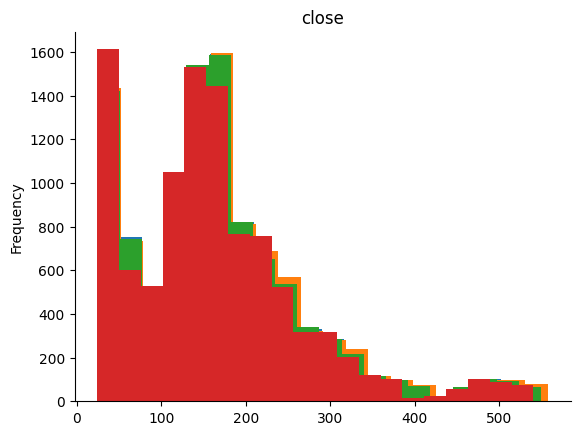

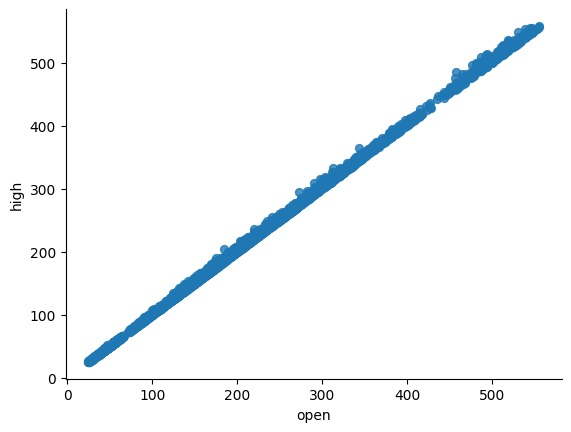

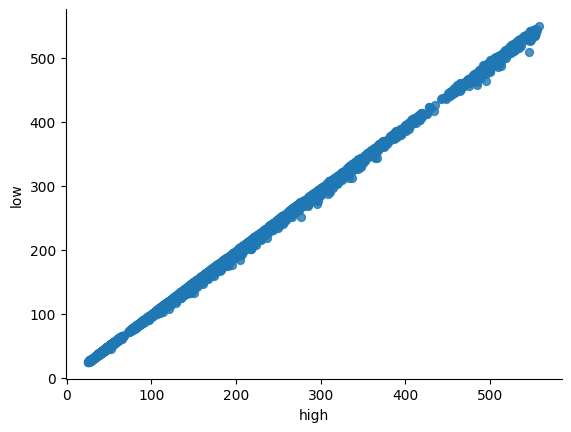

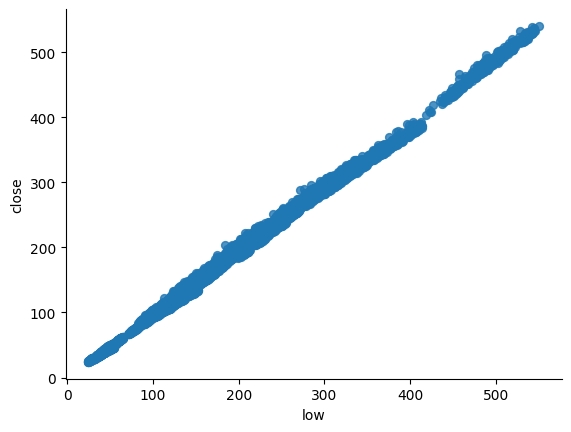

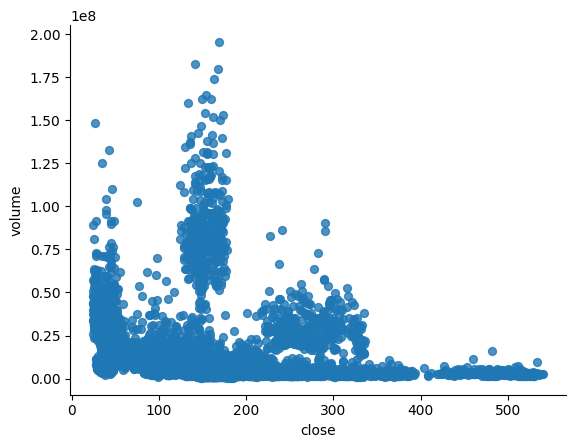

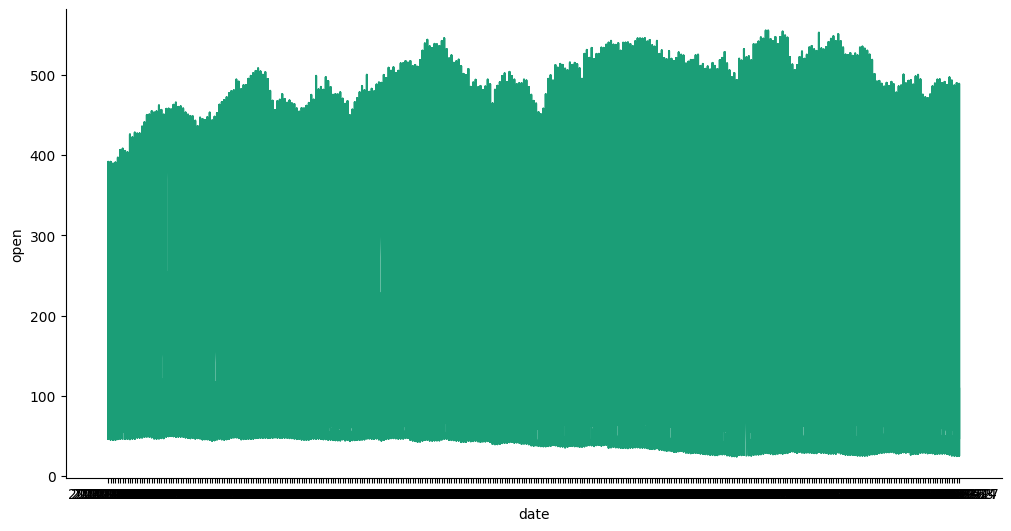

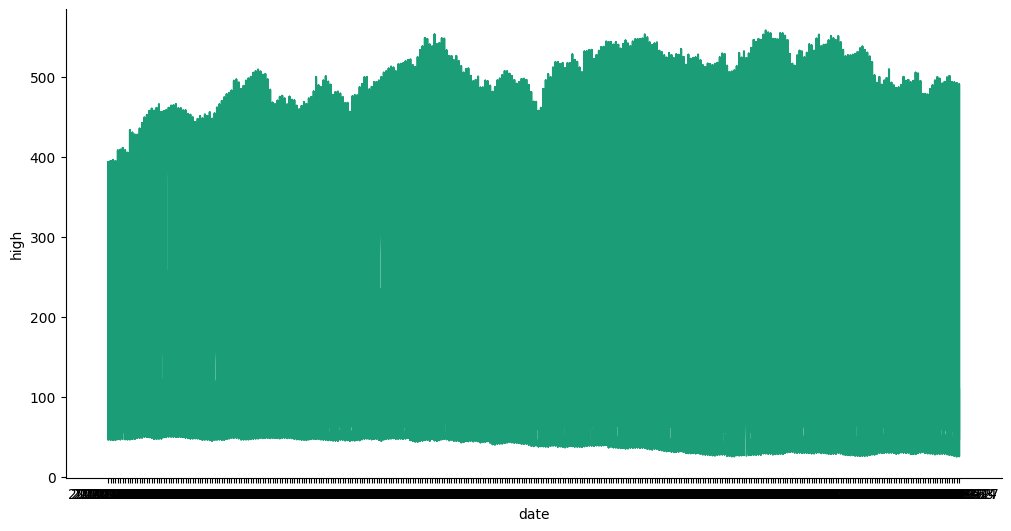

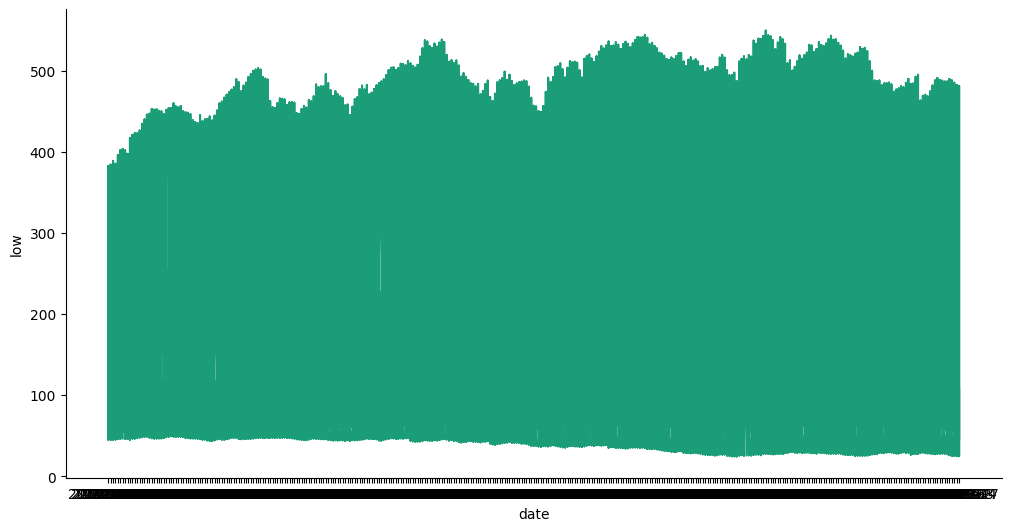

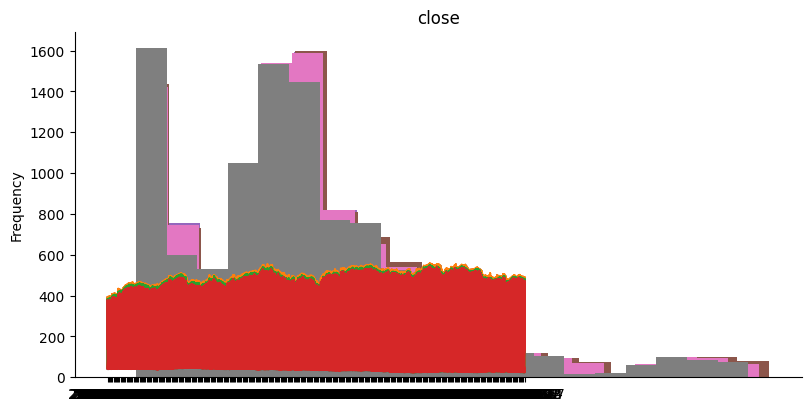

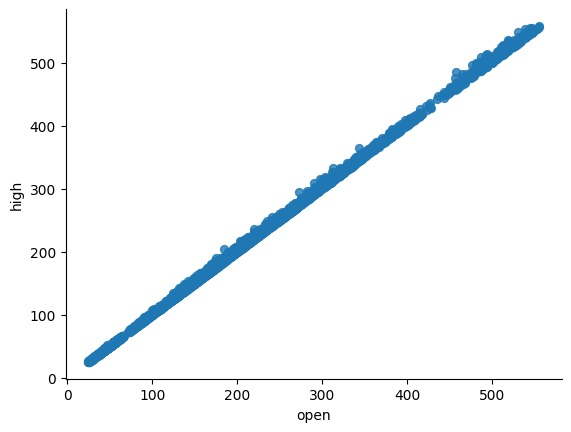

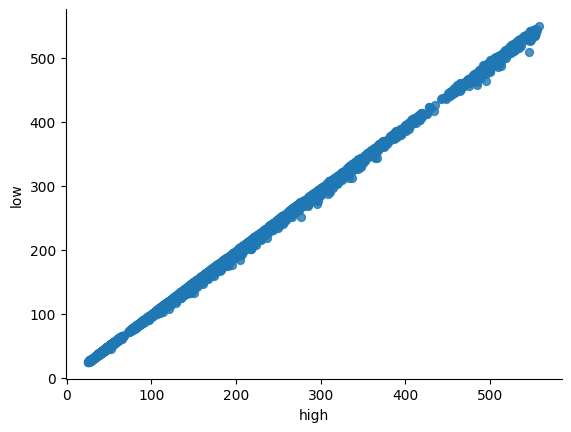

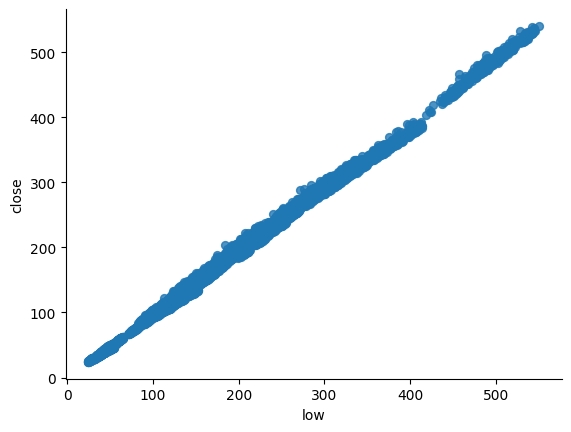

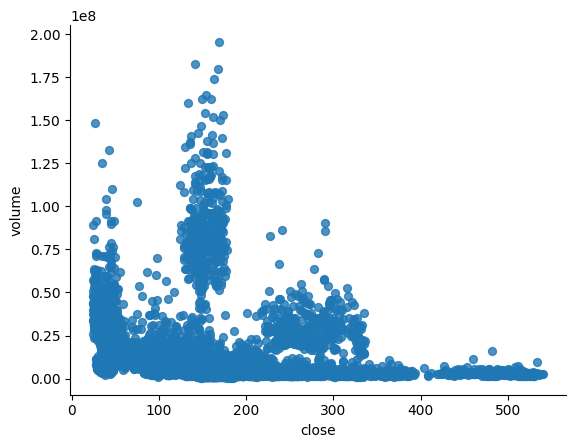

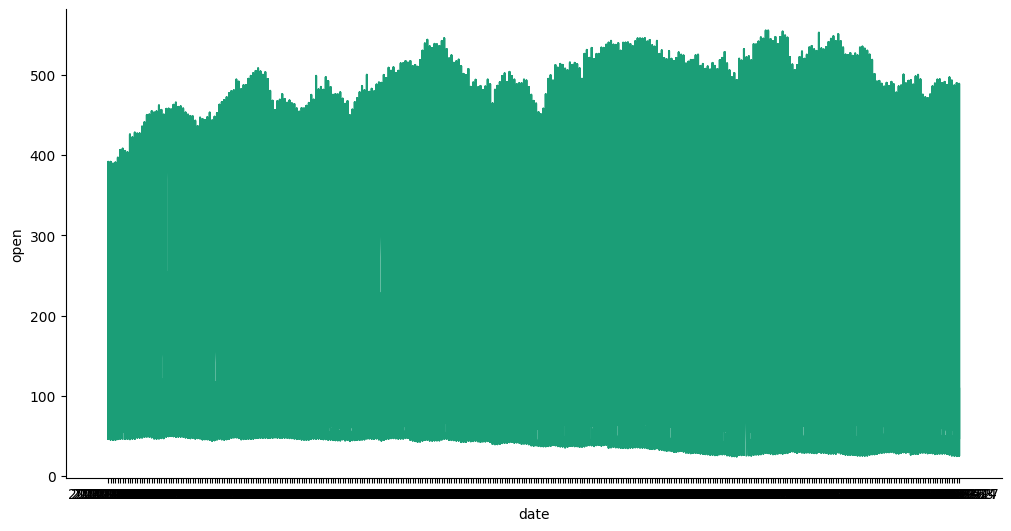

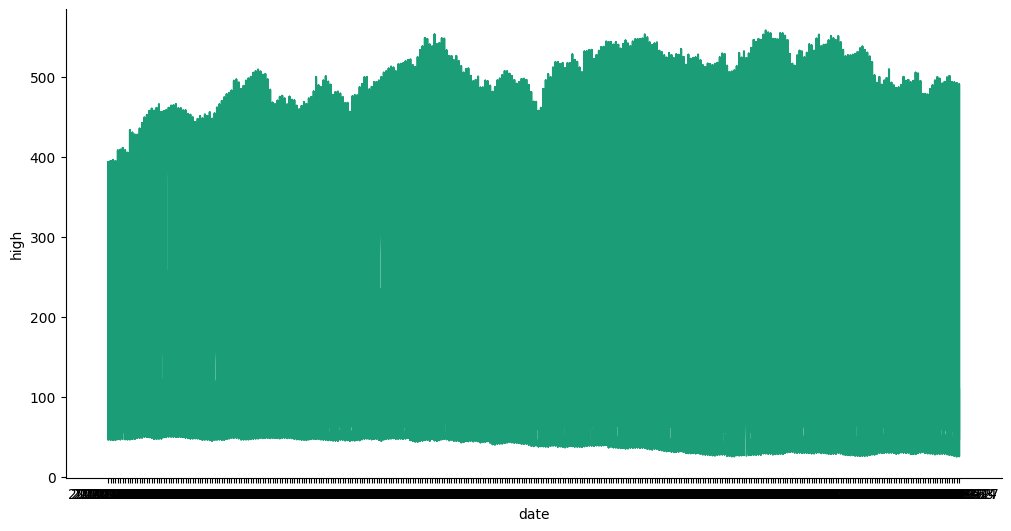

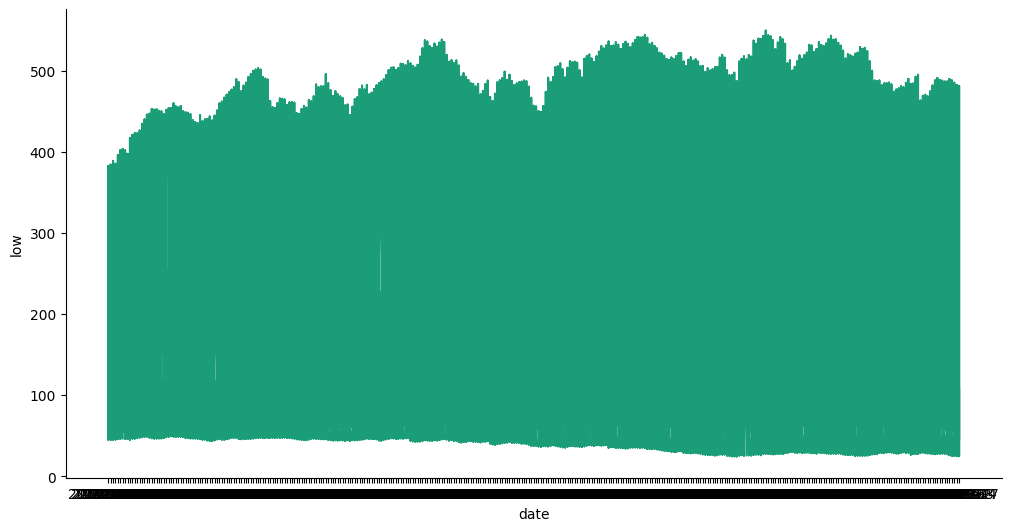

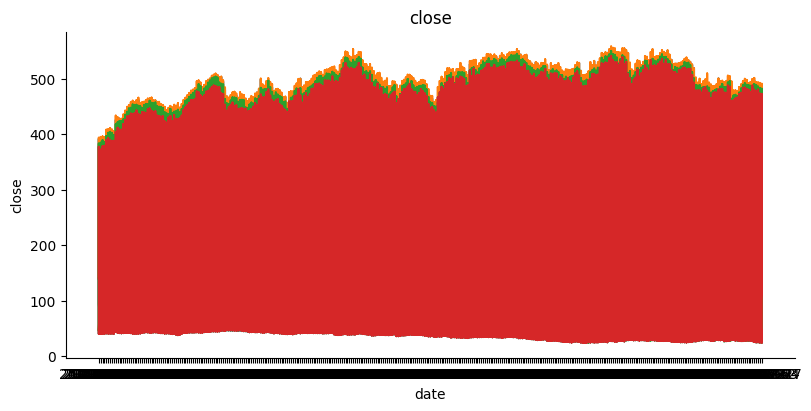

<Figure size 1500x500 with 0 Axes>

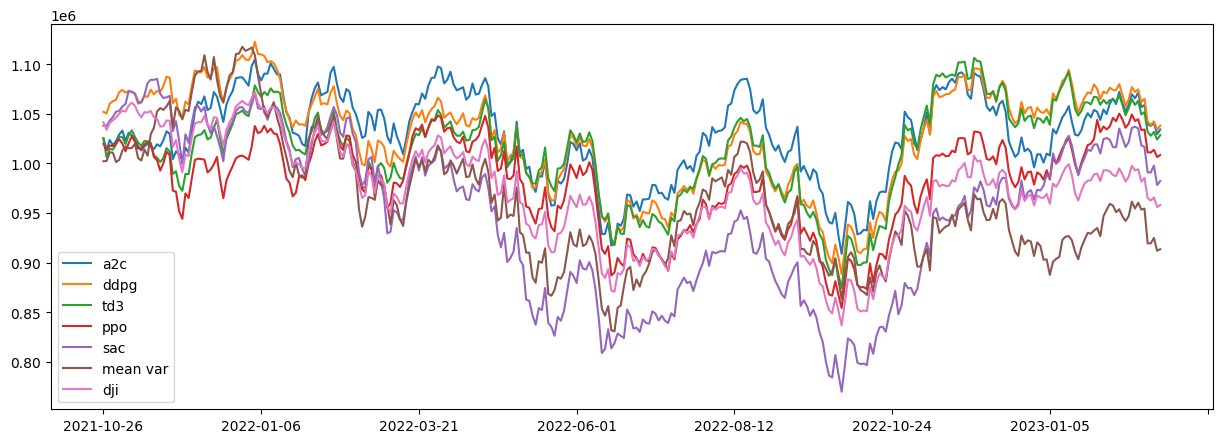

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();